In [1]:
import numpy as np
from collections import Counter

class DecisionNode:
    """
    决策树节点类
    
    属性:
    - feature: 用于分割的特征索引(如果是内部节点)
    - threshold: 分割特征的阈值(如果是内部节点)
    - left: 左子树(特征值 <= 阈值的样本)
    - right: 右子树(特征值 > 阈值的样本)
    - value: 如果是叶节点，存储预测的类别
    
    决策树有两种节点:
    1. 内部节点: 包含feature和threshold，用于分割数据
    2. 叶节点: 包含value，存储最终的预测结果
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature      # 用于分割的特征索引(列索引)
        self.threshold = threshold  # 分割阈值(数值)
        self.left = left            # 左子树(DecisionNode对象)
        self.right = right         # 右子树(DecisionNode对象)
        self.value = value          # 叶节点的预测值(类别)

In [6]:
class DecisionTree:
    """
    决策树分类器
    
    参数:
    - max_depth: 树的最大深度，防止过拟合
    - min_samples_split: 分割节点所需的最小样本数
    
    方法:
    - fit(): 训练决策树
    - predict(): 使用训练好的树进行预测
    """
    
    def __init__(self, max_depth=100, min_samples_split=2):
        self.max_depth = max_depth              # 树的最大深度
        self.min_samples_split = min_samples_split  # 节点分割所需最小样本数
        self.root = None        # 树的根节点
        
    def _is_finished(self, depth, n_class_labels, n_samples):
        """
        检查是否应该停止递归(即当前节点是否应该成为叶节点)
        
        参数:
        - depth: 当前节点的深度
        - n_class_labels: 当前节点样本中的类别数量
        - n_samples: 当前节点样本数量
        
        返回:
        - True: 应该停止(成为叶节点)
        - False: 应该继续分割
        """
        # 停止条件1: 达到最大深度
        # 停止条件2: 所有样本属于同一类别
        # 停止条件3: 样本数小于最小分割要求
        if (depth >= self.max_depth 
            or n_class_labels == 1 
            or n_samples < self.min_samples_split):
            return True
        return False
    def _entropy(self, y):
        """
        计算熵(混乱度)，用于衡量数据集的不纯度
        
        熵公式: H = -Σ(p_i * log2(p_i)), p_i是第i类样本的比例
        
        参数:
        - y: 目标值数组(类别标签)
        
        返回:
        - 熵值(数值)
        """
        # 计算每个类别出现的比例
        proportions = np.bincount(y) / len(y)
        # 计算熵: -Σ(p*log2(p))
        entropy = -np.sum([p * np.log2(p) for p in proportions if p > 0])
        return entropy
    def _create_split(self, X, thresh):
        """
        根据阈值将数据集分成两部分
        
        参数:
        - X: 单个特征列的数据
        - thresh: 分割阈值
        
        返回:
        - left_idx: 左子集的索引(<=阈值)
        - right_idx: 右子集的索引(>阈值)
        """
        left_idx = np.argwhere(X <= thresh).flatten()  # 满足条件的样本索引
        right_idx = np.argwhere(X > thresh).flatten()  # 不满足条件的样本索引
        return left_idx, right_idx
    def _information_gain(self, X, y, thresh):
        """
        计算信息增益，用于评估分割的好坏
        
        信息增益 = 父节点的熵 - 子节点的加权平均熵
        
        参数:
        - X: 单个特征列的数据
        - y: 对应的类别标签
        - thresh: 分割阈值
        
        返回:
        - 信息增益值
        """
        # 父节点的熵
        parent_loss = self._entropy(y)
        
        # 创建分割
        left_idx, right_idx = self._create_split(X, thresh)
        
        # 如果分割后有一边没有样本，信息增益为0
        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0
        
        # 计算子节点的加权平均熵
        n = len(y)  # 总样本数
        n_l, n_r = len(left_idx), len(right_idx)  # 左右子集样本数
        e_l, e_r = self._entropy(y[left_idx]), self._entropy(y[right_idx])  # 左右子集熵
        
        # 子节点的加权平均熵 = (左样本数/总样本数)*左熵 + (右样本数/总样本数)*右熵
        child_loss = (n_l / n) * e_l + (n_r / n) * e_r
        
        # 信息增益 = 父熵 - 子加权平均熵
        return parent_loss - child_loss
    
    def _best_split(self, X, y, features):
        """
        寻找最佳分割特征和阈值
        
        参数:
        - X: 特征矩阵
        - y: 目标值
        - features: 考虑的特征索引列表
        
        返回:
        - best_feat: 最佳分割特征的索引
        - best_thresh: 最佳分割阈值
        """
        # 初始化最佳分割信息
        split = {'score': -1, 'feat': None, 'thresh': None}
        
        # 遍历所有候选特征
        for feat in features:
            X_feat = X[:, feat]  # 获取该特征列的所有值
            
            # 考虑该特征的所有唯一值作为候选阈值
            thresholds = np.unique(X_feat)
            
            # 遍历所有候选阈值
            for thresh in thresholds:
                # 计算当前分割的信息增益
                score = self._information_gain(X_feat, y, thresh)
                
                # 如果找到更好的分割，更新最佳分割
                if score > split['score']:
                    split['score'] = score
                    split['feat'] = feat
                    split['thresh'] = thresh
        
        # 返回最佳分割特征和阈值
        return split['feat'], split['thresh']
    def _build_tree(self, X, y, depth=0):
        """
        递归构建决策树
        
        参数:
        - X: 特征矩阵
        - y: 目标值
        - depth: 当前深度
        
        返回:
        - DecisionNode对象(树的节点)
        """
        # 获取样本数和特征数
        n_samples, n_features = X.shape
        # 获取当前节点的类别数量
        n_class_labels = len(np.unique(y))
        
        # 检查是否应该停止递归(成为叶节点)
        if self._is_finished(depth, n_class_labels, n_samples):
            # 叶节点的值是当前节点样本中最常见的类别
            most_common_label = np.argmax(np.bincount(y))
            return DecisionNode(value=most_common_label)
        
        # 随机选择特征子集(增加多样性，可用于随机森林)
        # 这里我们选择所有特征，但顺序是随机的
        rnd_feats = np.random.choice(n_features, n_features, replace=False)
        
        # 找到最佳分割特征和阈值
        best_feat, best_thresh = self._best_split(X, y, rnd_feats)
        
        # 根据最佳分割特征和阈值分割数据
        left_idx, right_idx = self._create_split(X[:, best_feat], best_thresh)
        
        # 递归构建左子树和右子树
        left = self._build_tree(X[left_idx, :], y[left_idx], depth + 1)
        right = self._build_tree(X[right_idx, :], y[right_idx], depth + 1)
        
        # 返回当前节点(内部节点)，包含分割信息和左右子树
        return DecisionNode(best_feat, best_thresh, left, right)
    def _traverse_tree(self, x, node):
        """
        遍历决策树进行预测
        
        参数:
        - x: 单个样本的特征向量
        - node: 当前节点
        
        返回:
        - 预测的类别
        """
        # 如果到达叶节点，返回预测值
        if node.value is not None:
            return node.value
        
        # 否则根据特征和阈值决定走左子树还是右子树
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    def fit(self, X, y):
        """训练决策树"""
        self.root = self._build_tree(X, y)
    
    def predict(self, X):
        """预测"""
        # 对每个样本遍历决策树得到预测结果
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 加载鸢尾花数据集
# 这是一个经典数据集，包含150个样本，4个特征，3个类别
iris = load_iris()
X, y = iris.data, iris.target  # X是特征矩阵，y是类别标签

# 将数据集划分为训练集和测试集
# test_size=0.2表示20%的数据作为测试集
# random_state=42确保每次划分结果相同
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 创建决策树分类器实例
# max_depth=10表示树的最大深度为10
clf = DecisionTree(max_depth=10)

# 训练模型(构建决策树)
clf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = clf.predict(X_test)

# 计算准确率: 正确预测的比例
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")  # 打印准确率，保留2位小数

Accuracy: 1.00


In [12]:
!pip install graphviz

     |████████████████████████████████| 47 kB 165 kB/s eta 0:00:01


In [13]:
import graphviz
print("Graphviz已成功安装！")

Graphviz已成功安装！


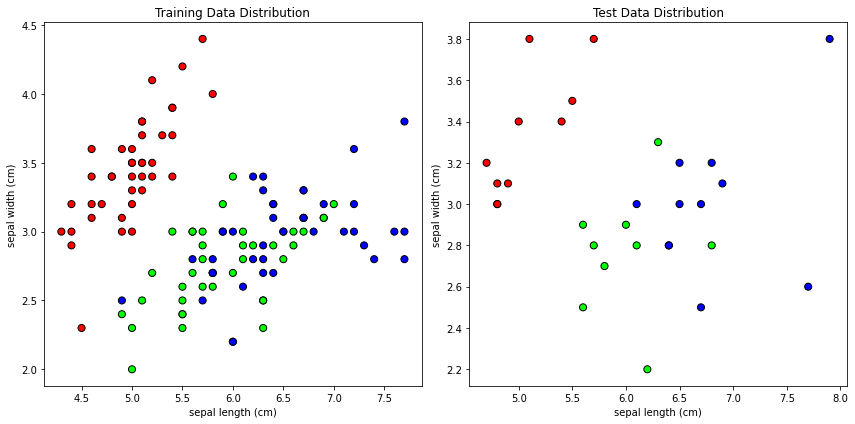

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 设置颜色映射
cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])  # 红、绿、蓝对应三类

# 绘制数据分布
plt.figure(figsize=(12, 6))

# 选择两个特征进行可视化（鸢尾花数据集的前两个特征）
feature1, feature2 = 0, 1  # 可以修改这两个索引查看不同特征的组合

# 绘制训练集分布
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, feature1], X_train[:, feature2], c=y_train, cmap=cmap, 
            edgecolor='k', s=50)
plt.xlabel(iris.feature_names[feature1])
plt.ylabel(iris.feature_names[feature2])
plt.title("Training Data Distribution")

# 绘制测试集分布
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, feature1], X_test[:, feature2], c=y_test, cmap=cmap, 
            edgecolor='k', s=50)
plt.xlabel(iris.feature_names[feature1])
plt.ylabel(iris.feature_names[feature2])
plt.title("Test Data Distribution")

plt.tight_layout()
plt.show()

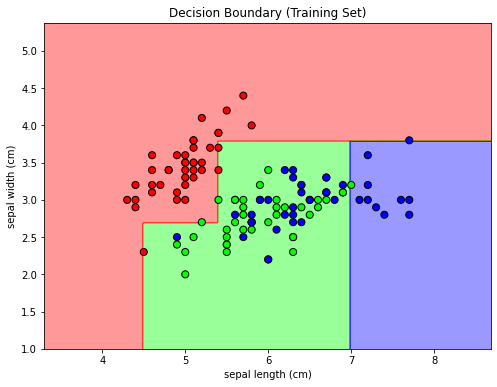

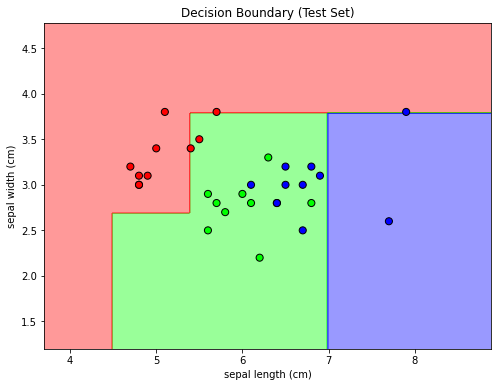

In [15]:
def plot_decision_boundary(clf, X, y, feature_names, title):
    """
    绘制决策边界
    
    参数:
    - clf: 训练好的分类器
    - X: 特征数据
    - y: 目标值
    - feature_names: 特征名称列表
    - title: 图表标题
    """
    # 设置绘图范围
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # 生成网格点
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # 预测每个网格点的类别
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel()), np.zeros_like(xx.ravel())])
    Z = Z.reshape(xx.shape)
    
    # 绘制决策边界和区域
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, 
                edgecolor='k', s=50)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.show()

# 只使用前两个特征进行训练和可视化
X_train_2d = X_train[:, [0, 1]]
X_test_2d = X_test[:, [0, 1]]

# 重新训练一个只使用两个特征的决策树
clf_2d = DecisionTree(max_depth=3)  # 减小深度使边界更简单
clf_2d.fit(X_train_2d, y_train)

# 绘制训练集决策边界
plot_decision_boundary(clf_2d, X_train_2d, y_train, 
                      iris.feature_names[:2], 
                      "Decision Boundary (Training Set)")

# 绘制测试集决策边界
plot_decision_boundary(clf_2d, X_test_2d, y_test, 
                      iris.feature_names[:2], 
                      "Decision Boundary (Test Set)")